# Search for Pulse Reset
Using the Keysight AWG

In [1]:
cd ..

C:\Users\qlab\Documents\GitHub\Auspex


In [2]:
from experiments.Pulse_Switching_Search_Reset import ResetSearchExperiment
from auspex.filters.io import WriteToHDF5
from auspex.filters.plot import Plotter
from auspex.filters.average import Averager
import datetime
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [3]:
sample_name = "CSHE-Die7-C6R7"
date = datetime.datetime.today().strftime('%Y-%m-%d')
file_path = "data\CSHE-Switching\{samp:}\{samp:}-ResetSearch_{date:}.h5".format(samp=sample_name, date=date)

exp = ResetSearchExperiment()
exp.field.value     = 0.007
exp.duration.value  = 5e-9
exp.measure_current = 3e-6
amps = np.linspace(-0.95, 0.95, 75)
amps = np.append(amps, np.flipud(amps))
exp.amplitudes = amps
exp.init_streams()

In [7]:
wr = WriteToHDF5(file_path)
avg_sample = Averager('sample')
fig1       = Plotter(name="Pulse Reset Search", plot_dims=1, notebook=True)
edges = [(exp.voltage, avg_sample.sink),
         (avg_sample.final_average, wr.sink),
         (avg_sample.partial_average, fig1.sink)]
exp.set_graph(edges)
exp.run_sweeps()

C:\Users\qlab\Anaconda3\lib\site-packages\bokeh\util\deprecation.py:33: BokehDeprecationWarning: bokeh.io.hplot() was deprecated in Bokeh 0.12.0 and will be removed, use bokeh.models.layouts.Row instead.
  warn(message)


Loading BokehJS ...

Killing bokeh server thread 3644
Killing child process 1008


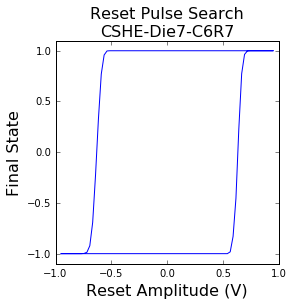

In [16]:
%matplotlib inline
with h5py.File(wr.filename) as f:
    amps = f['amplitude'].value[:]
    reps = f['repeat'].value[:]
    Vs   = f['data'].value['voltage'][:]
    Vs = Vs.reshape(reps.size, amps.size)
    Vs = Vs>(0.5*(Vs.max()+Vs.min()))
    Vs = 2*Vs-1
    fig = plt.figure(figsize=(4,4))
    plt.ylim(Vs.min()*1.1, Vs.max()*1.1)
    plt.xlabel('Reset Amplitude (V)', size=16)
    plt.ylabel(r'Final State', size=16)
    plt.title('Reset Pulse Search\n{}'.format(sample_name), size=16)
    plt.plot(amps, Vs.mean(axis=0))
    plt.show()

## Add a Field Sweep to Identify the Field-Dependence

In [4]:
sample_name = "CSHE-Die7-C6R7"
date = datetime.datetime.today().strftime('%Y-%m-%d')
file_path = "data\CSHE-Switching\{samp:}\{samp:}-ResetSearch-vs-Field_{date:}.h5".format(samp=sample_name, date=date)

exp = ResetSearchExperiment()
exp.duration.value  = 5e-9
exp.measure_current = 3e-6
amps = np.linspace(-0.95, 0.95, 75)
amps = np.append(amps, np.flipud(amps))
exp.amplitudes = amps
exp.init_streams()
exp.add_sweep(exp.field, np.arange(0.004, 0.015, 0.001))

<SweepAxis(name=field,length=11,unit=T,value=0.004,unstructured=False>

In [5]:
wr = WriteToHDF5(file_path)
avg_sample = Averager('sample')
fig1       = Plotter(name="Pulse Reset Search vs. Field", plot_dims=1, notebook=True)
edges = [(exp.voltage, avg_sample.sink),
         (avg_sample.final_average, wr.sink),
         (avg_sample.partial_average, fig1.sink)]
exp.set_graph(edges)
exp.run_sweeps()

C:\Users\qlab\Anaconda3\lib\site-packages\bokeh\util\deprecation.py:33: BokehDeprecationWarning: bokeh.io.hplot() was deprecated in Bokeh 0.12.0 and will be removed, use bokeh.models.layouts.Row instead.
  warn(message)


Loading BokehJS ...

Killing bokeh server thread 5676
Killing child process 8328


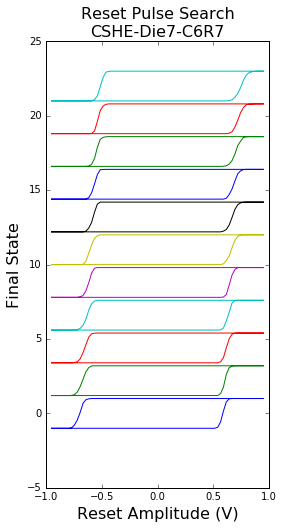

In [10]:
%matplotlib inline
with h5py.File(wr.filename) as f:
    amps   = f['amplitude'].value[:]
    reps   = f['repeat'].value[:]
    fields = f['field'].value[:]
    Vs     = f['data'].value['voltage'][:]
    Vs = Vs.reshape(fields.size, reps.size, amps.size)
    Vs = Vs>(0.5*(Vs.max()+Vs.min()))
    Vs = 2*Vs-1
    fig = plt.figure(figsize=(4,8))
    plt.xlabel('Reset Amplitude (V)', size=16)
    plt.ylabel('Final State', size=16)
    plt.title('Reset Pulse Search\n{}'.format(sample_name), size=16)
    
    for i, trace in enumerate(Vs.mean(axis=1)):
        plt.plot(amps, trace + 2.2*i)
    plt.show()

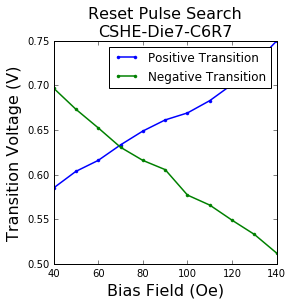

In [22]:
%matplotlib inline
with h5py.File(wr.filename) as f:
    amps   = f['amplitude'].value[:]
    reps   = f['repeat'].value[:]
    fields = f['field'].value[:]*1e4
    Vs     = f['data'].value['voltage'][:]
    Vs = Vs.reshape(fields.size, reps.size, amps.size)
    Vs = Vs>(0.5*(Vs.max()+Vs.min()))
    Vs = 2*Vs-1
    fig = plt.figure(figsize=(4,4))
    plt.xlabel('Bias Field (Oe)', size=16)
    plt.ylabel('Transition Voltage (V)', size=16)
    plt.title('Reset Pulse Search\n{}'.format(sample_name), size=16)
    
    def interp_thresh(xs, ys, i, t=0):
        x1, x2, y1, y2 = xs[i], xs[i+1], ys[i], ys[i+1]
        return x1 + (t-y1)*(x2-x1)/(y2-y1)
    
    trans_pos = []
    trans_neg = []
    for i, trace in enumerate(Vs.mean(axis=1)):
        where_pos = np.where(np.diff(np.sign(trace)))[0][0]
        where_neg = np.where(np.diff(np.sign(trace)))[0][-1]
        trans_pos.append(interp_thresh(amps,trace,where_pos))
        trans_neg.append(interp_thresh(amps,trace,where_neg))
    
    plt.plot(fields, trans_pos, '.-', lw=1.5, label='Positive Transition')
    plt.plot(fields, np.abs(trans_neg), '.-', lw=1.5, label='Negative Transition')
    plt.legend()
    plt.show()